In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')


/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s4e7/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e7/test.csv")

In [3]:
def converting_datatypes(df):
    df = df.copy()

    # Converting data types
    df['Gender'] = df['Gender'].astype('category')
    df['Vehicle_Age'] = df['Vehicle_Age'].astype('category')
    df['Vehicle_Damage'] = df['Vehicle_Damage'].astype('category')
    df['Age'] = df['Age'].astype('int8')
    df['Driving_License'] = df['Driving_License'].astype('int8')
    df['Region_Code'] = df['Region_Code'].astype('int8')
    df['Previously_Insured'] = df['Previously_Insured'].astype('int8')
    df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int16')
    df['Vintage'] = df['Vintage'].astype('int16')
    df['Response'] = df['Response'].astype('int8')
    print(df.info(memory_usage='deep'))
    
    return df

In [4]:
train = converting_datatypes(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   Gender                category
 2   Age                   int8    
 3   Driving_License       int8    
 4   Region_Code           int8    
 5   Previously_Insured    int8    
 6   Vehicle_Age           category
 7   Vehicle_Damage        category
 8   Annual_Premium        int32   
 9   Policy_Sales_Channel  int16   
 10  Vintage               int16   
 11  Response              int8    
dtypes: category(3), int16(2), int32(1), int64(1), int8(5)
memory usage: 263.3 MB
None


# ***EDA***

In [5]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35,0,1-2 Year,Yes,65101,124,187,0
1,1,Male,43,1,28,0,> 2 Years,Yes,58911,26,288,1
2,2,Female,25,1,14,1,< 1 Year,No,38043,152,254,0
3,3,Female,35,1,1,0,1-2 Year,Yes,2630,156,76,0
4,4,Female,36,1,15,1,1-2 Year,No,31951,152,294,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   Gender                category
 2   Age                   int8    
 3   Driving_License       int8    
 4   Region_Code           int8    
 5   Previously_Insured    int8    
 6   Vehicle_Age           category
 7   Vehicle_Damage        category
 8   Annual_Premium        int32   
 9   Policy_Sales_Channel  int16   
 10  Vintage               int16   
 11  Response              int8    
dtypes: category(3), int16(2), int32(1), int64(1), int8(5)
memory usage: 263.3 MB


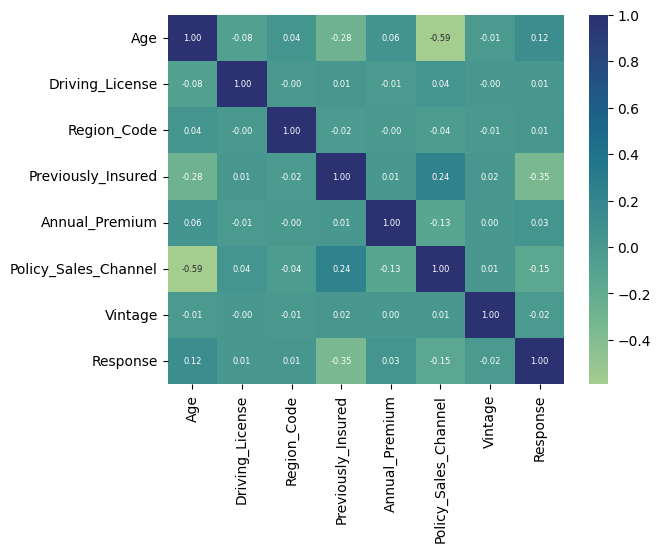

In [7]:
num = train.select_dtypes(include=['int8', 'int16', 'int32'])
sns.heatmap(num.corr(), cmap='crest', annot=True, annot_kws={"size": 6}, fmt=".2f")
plt.show()

In [8]:
train['Region_Code'].value_counts().head()

Region_Code
28    3451062
8     1021036
46     578208
41     557581
15     403977
Name: count, dtype: int64

# ***PREPROCESSING***

In [9]:
cat = train[['Vehicle_Age', 'Vehicle_Damage', 'Gender']]

train = pd.get_dummies(train, drop_first=True)

In [10]:
test = pd.get_dummies(test, drop_first=True)

# ***FEATURE ENGINEERING***

In [11]:
train['Age_log'] = np.log1p(train['Age'])
train['Is_Region_28'] = train['Region_Code'].apply(lambda x: 1 if x == 28 else 0)

In [12]:
test['Age_log'] = np.log1p(test['Age'])
test['Is_Region_28'] = test['Region_Code'].apply(lambda x: 1 if x == 28 else 0)

# ***TRAIN***

In [13]:
features_to_drop = ['id', 'Age', 'Annual_Premium', 'Vintage', 'Region_Code', 
                    'Driving_License', 'Response']

X = train.drop(features_to_drop, axis=1)
y = train['Response']

In [14]:
features_to_drop = ['id', 'Age', 'Annual_Premium', 'Vintage', 'Region_Code', 
                    'Driving_License']

test = test.drop(features_to_drop, axis=1)

In [15]:
from sklearn.model_selection import train_test_split

# Small train size to reduce fit time 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=1)

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

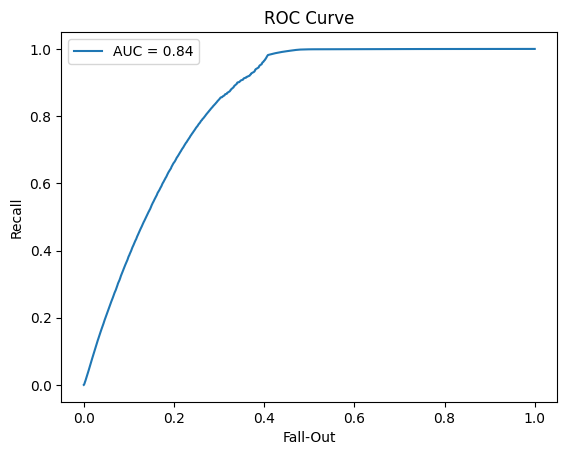

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_proba = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('Fall-Out')
plt.ylabel('Recall')
plt.title('ROC Curve')
plt.legend()
plt.show()